In [1]:
import os
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib
from tqdm import tqdm
from napatrackmater.Trackvector import (
    BROWNIAN_FEATURES
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


/home/debian/anaconda3/envs/capedenv/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
2024-12-13 21:13:11.817975: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-13 21:13:12.091960: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-13 21:13:13.491112: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.s

In [2]:
dataset_name = 'Sixth'
home_folder = '/home/debian/jz/'
channel = 'nuclei_'
tracking_directory = f'{home_folder}Mari_Data_Oneat/Mari_{dataset_name}_Dataset_Analysis/nuclei_membrane_tracking/'
data_frames_dir = os.path.join(tracking_directory, f'dataframes/')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

normalized_dataframe = os.path.join(data_frames_dir , f'goblet_basal_dataframe_normalized_{channel}predicted_morpho_feature_attention_shallowest_litest.csv')
print(f'reading data from {normalized_dataframe}')
tracks_dataframe = pd.read_csv(normalized_dataframe)
save_dir = os.path.join(tracking_directory, f'{channel}phasespaces')
Path(save_dir).mkdir(exist_ok=True)
deltat = 10
class_map_gbr = {
        0: "Basal",
        1: "Radial",
        2: "Goblet"
    }

reading data from /home/debian/jz/Mari_Data_Oneat/Mari_Sixth_Dataset_Analysis/nuclei_membrane_tracking/dataframes/goblet_basal_dataframe_normalized_nuclei_predicted_morpho_feature_attention_shallowest_litest.csv


In [3]:
all_trackmate_ids = [trackid for trackid in tracks_dataframe['TrackMate Track ID'].unique()]
result_dict = {cell_type: {} for cell_type in class_map_gbr.values()}
unique_time_points = tracks_dataframe['t'].unique()

for i, time_point in enumerate(unique_time_points):
    time_data = tracks_dataframe[tracks_dataframe['t'] == time_point]
    
    if i + 1 < len(unique_time_points):
        next_time_point = unique_time_points[i + 1]
        next_time_data = tracks_dataframe[tracks_dataframe['t'] == next_time_point]

        for cell_type in class_map_gbr.values():
            cell_type_data = time_data[time_data['Cell_Type'] == cell_type]
            

            if not cell_type_data.empty:
                if time_point not in result_dict[cell_type]:
                    result_dict[cell_type][time_point] = {}
                for trackmate_id in cell_type_data['TrackMate Track ID'].unique():
                    current_trackmate_id_data = cell_type_data[cell_type_data['TrackMate Track ID'] == trackmate_id]
                    for track_id in current_trackmate_id_data['Track ID'].unique():
                        track_features = current_trackmate_id_data[current_trackmate_id_data['Track ID'] == track_id][BROWNIAN_FEATURES].to_numpy()
                        
                        if not next_time_data.empty:
                            next_cell_type_data = next_time_data[next_time_data['TrackMate Track ID'] == trackmate_id]
                            next_track_features = next_cell_type_data[next_cell_type_data['Track ID'] == track_id][BROWNIAN_FEATURES].to_numpy()
                            if next_track_features.shape[0] > 0 :
                            
                                derivative_features = next_track_features[0,:] - track_features
                            

                                for feature_name in BROWNIAN_FEATURES:
                                    pair_key = f"{feature_name}"
                                    if derivative_features.shape[0] > 0:
                                        
                                        pairwise_values = np.stack(
                                            [track_features[:, BROWNIAN_FEATURES.index(feature_name)],
                                            derivative_features[:, BROWNIAN_FEATURES.index(feature_name)]],
                                            axis=1
                                        )

                                        if pair_key not in result_dict[cell_type][time_point]:
                                            result_dict[cell_type][time_point][pair_key] = []

                                        result_dict[cell_type][time_point][pair_key].append({
                                            'Track ID': int(track_id),  
                                            'Pairwise Values': pairwise_values
                                        })


In [4]:


def build_dataframe(result_dict):
    """Converts result_dict to a pandas DataFrame for plotting, including Track ID."""
    rows = []

    for cell_type, time_data in result_dict.items():
        for time_point, feature_dict in time_data.items():
            for feature_name, track_data in feature_dict.items():
                for track_entry in track_data:
                    track_id = track_entry['Track ID']
                    pairwise_array = track_entry['Pairwise Values']

                    for feature_value, derivative_value in pairwise_array:
                        rows.append({
                            'Cell Type': cell_type,
                            'Time Point': time_point,
                            'Feature phase space': feature_name,
                            'Track ID': track_id, 
                            'Feature Value': feature_value,
                            'Derivative Value': derivative_value
                        })

    df = pd.DataFrame(rows)
    return df




def plot_phasespace(df, title='phasespace',  dataset_name='dataset'):
    """Plots the phase space using seaborn's kdeplot for all time points in one plot per feature, with a color bar."""
    
    cmap = plt.cm.viridis
    norm = matplotlib.colors.Normalize(vmin=df['Time Point'].min(), vmax=df['Time Point'].max())

    for cell_type in df['Cell Type'].unique():
        cell_type_df = df[df['Cell Type'] == cell_type]
        
        for feature_name in cell_type_df['Feature phase space'].unique():
            phasespace_df = cell_type_df[cell_type_df['Feature phase space'] == feature_name]
            print(f"Plotting for {cell_type} and feature phase space {feature_name}")
            
            fig, ax = plt.subplots(figsize=(8, 10))

            for time_point in sorted(phasespace_df['Time Point'].unique()):
                time_df = phasespace_df[phasespace_df['Time Point'] == time_point]

                if len(time_df) < 2 or time_df['Feature Value'].nunique() < 2:
                    print(f"Skipping KDE for time {time_point} due to insufficient data.")
                    continue 

                color = cmap(norm(time_point))

                sns.kdeplot(
                    data=time_df,
                    x='Feature Value',
                    y='Derivative Value',
                    label=f"Time {time_point}",
                    alpha=0.5,
                    ax=ax,
                    color=color,
                    warn_singular=False
                )

            ax.set_xlabel(f'{feature_name}', fontsize=14)
            ax.set_ylabel(f'{feature_name}_derivative', fontsize=14)

            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([]) 
            cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
            cbar.set_label('Time Point', fontsize=14)

            ax.set_title(f"{title} - {cell_type} ({feature_name})", fontsize=16)
            ax.legend(title="Time Points", loc="upper right", fontsize=10)

          

            plot_filename = os.path.join(save_dir, f"{title}_{cell_type}_{feature_name}_{dataset_name}_phasespace.png")
            plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
            plt.show()
            plt.close()

          


def test_ergodicity(
    df, 
    time_delta=50, 
):
    """
    Tests ergodicity by comparing the average of time averages (tracks) with 
    the average of ensemble averages (time points) over specified time intervals.
    Saves comparison plots for each feature, iterating over all cell types.
    """
    
    os.makedirs(save_dir, exist_ok=True)  # Ensure output directory exists
    for cell_type in df['Cell Type'].unique():
        # Iterate over all unique features in the dataframe
        for feature_name in df['Feature phase space'].unique():
            ergodicity_results = []
            #failed_intervals_count = 0

        
            cell_type_df = df[df['Cell Type'] == cell_type]
            total_time_points = len(cell_type_df['Time Point'].unique())
            time_points = sorted(cell_type_df['Time Point'].unique())

            for start_time in tqdm(range(0, total_time_points + 2 * time_delta, time_delta)):
                if start_time + time_delta >= total_time_points:
                    start_time = total_time_points - time_delta

                end_time = min(start_time + time_delta, total_time_points)
                time_interval_points = time_points[start_time:end_time]

                interval_df = cell_type_df[cell_type_df['Time Point'].isin(time_interval_points)]
                feature_df = interval_df[interval_df['Feature phase space'] == feature_name]

                # Time averages for each track over the interval
                track_time_averages = []
                for track_id in feature_df['Track ID'].unique():
                    track_df = feature_df[feature_df['Track ID'] == track_id]
                    time_avg_feature = np.mean(track_df['Feature Value'].values)
                    track_time_averages.append(time_avg_feature)

                # Ensemble averages for each time point in the interval
                time_point_ensemble_averages = []
                for time_point in time_interval_points:
                    time_df = feature_df[feature_df['Time Point'] == time_point]
                    ensemble_avg_feature = np.mean(time_df['Feature Value'].values)
                    time_point_ensemble_averages.append(ensemble_avg_feature)

                # Compare average of time averages with average of ensemble averages
                avg_time_avg_feature = np.mean(track_time_averages)
                avg_ensemble_avg_feature = np.mean(time_point_ensemble_averages)
                diff = abs(avg_time_avg_feature - avg_ensemble_avg_feature)

                # Statistical threshold for difference
                #tolerance = 0.05 * max(avg_time_avg_feature, avg_ensemble_avg_feature, 1e-6)  # 5% relative tolerance

                #if diff > tolerance:
                #    failed_intervals_count += 1
                #    if failed_intervals_count >= max_failed_intervals:
                #        print(f"Too many failed intervals for {feature_name} in {cell_type}. Ergodicity not reached.")
                #        continue

                # Record successful ergodic intervals
                ergodicity_results.append({
                    'Cell Type': cell_type,
                    'Feature': feature_name,
                    'Interval': f"{start_time}-{end_time}",
                    'Time Avg': avg_time_avg_feature,
                    'Ensemble Avg': avg_ensemble_avg_feature,
                    'Difference': diff,
                })

            # Save results and plot for each feature
            if ergodicity_results:
                ergodicity_df = pd.DataFrame(ergodicity_results)
                sns.set(style="whitegrid")
                plt.figure(figsize=(10, 6))

                # Plot each cell type's results
                for cell_type in ergodicity_df['Cell Type'].unique():
                    cell_type_data = ergodicity_df[ergodicity_df['Cell Type'] == cell_type]
                    sns.lineplot(
                        data=cell_type_data, 
                        x="Interval", 
                        y="Time Avg", 
                        label=f"{cell_type} Time Avg", 
                        marker="o"
                    )
                    sns.lineplot(
                        data=cell_type_data, 
                        x="Interval", 
                        y="Ensemble Avg", 
                        label=f"{cell_type} Ensemble Avg", 
                        marker="s"
                    )

                

                plt.title(f"Ergodicity Test for {cell_type}_{feature_name}")
                plt.ylabel("Value")
                plt.xlabel("Time Interval")
                plt.legend()
                plt.xticks(rotation=45)
                plt.tight_layout()

                # Save plot for each feature
                plot_path = os.path.join(save_dir, f"ergodicity_{cell_type}_{feature_name}.png")
                plt.savefig(plot_path)
                plt.show()
                plt.close()
                print(f"Saved plot for {feature_name} at {plot_path}")
            else:
                print(f"No ergodic intervals detected for feature {cell_type}_{feature_name}.")


            

In [5]:
feature_dataframe = build_dataframe(result_dict)


100%|██████████| 38/38 [01:10<00:00,  1.85s/it]


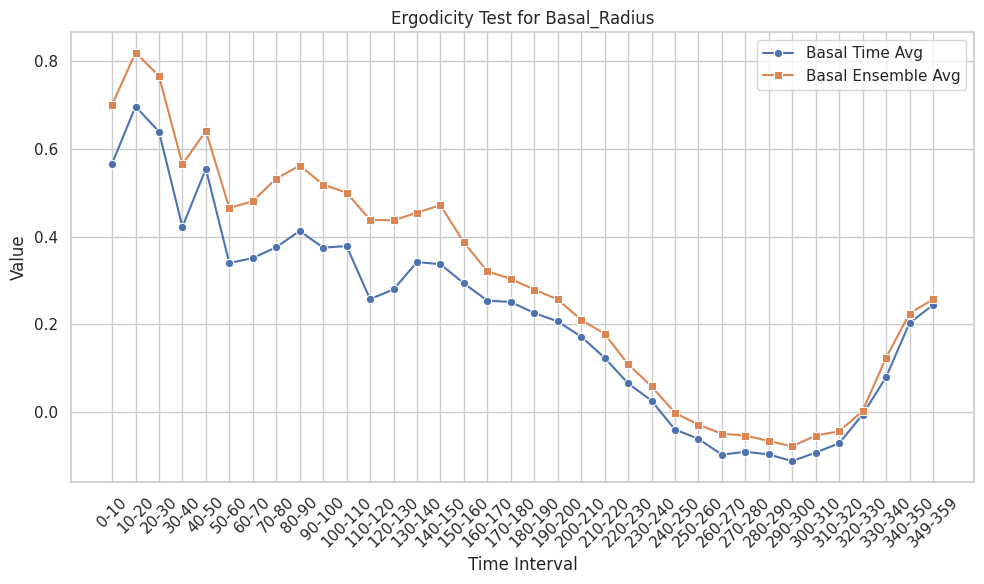

Saved plot for Radius at /home/debian/jz/Mari_Data_Oneat/Mari_Sixth_Dataset_Analysis/nuclei_membrane_tracking/nuclei_phasespaces/ergodicity_Basal_Radius.png


100%|██████████| 38/38 [01:16<00:00,  2.00s/it]


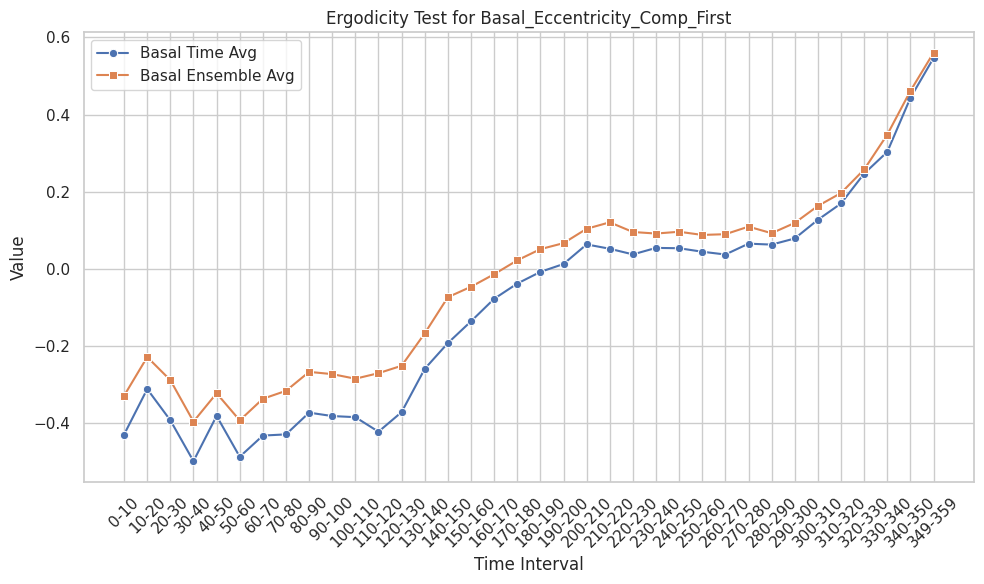

Saved plot for Eccentricity_Comp_First at /home/debian/jz/Mari_Data_Oneat/Mari_Sixth_Dataset_Analysis/nuclei_membrane_tracking/nuclei_phasespaces/ergodicity_Basal_Eccentricity_Comp_First.png


100%|██████████| 38/38 [01:10<00:00,  1.86s/it]


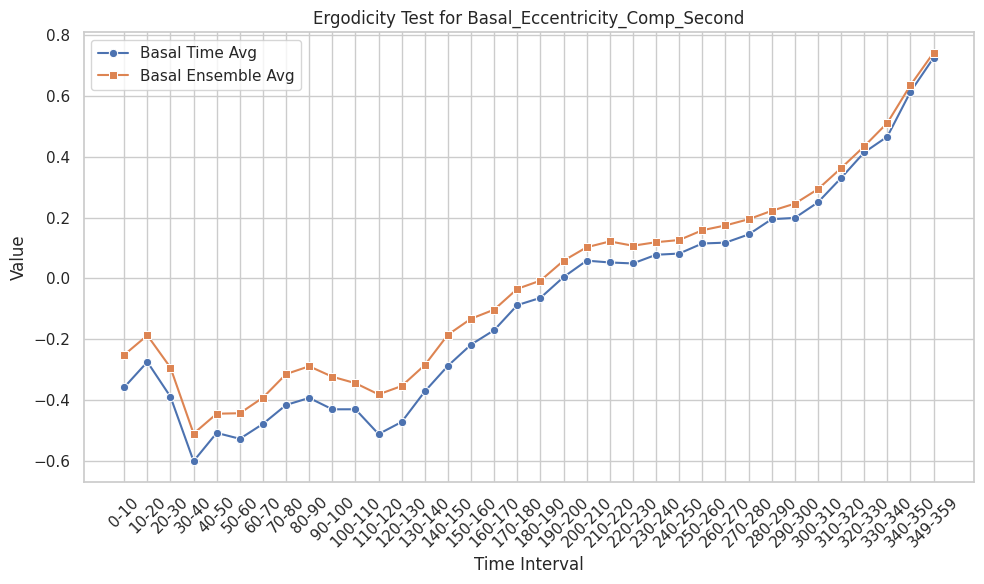

Saved plot for Eccentricity_Comp_Second at /home/debian/jz/Mari_Data_Oneat/Mari_Sixth_Dataset_Analysis/nuclei_membrane_tracking/nuclei_phasespaces/ergodicity_Basal_Eccentricity_Comp_Second.png


100%|██████████| 38/38 [01:15<00:00,  2.00s/it]


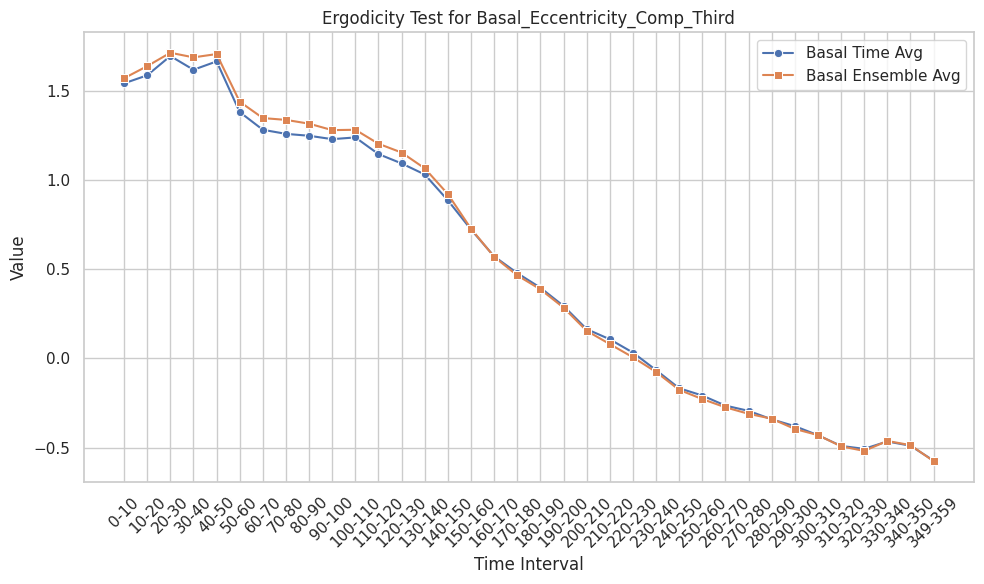

Saved plot for Eccentricity_Comp_Third at /home/debian/jz/Mari_Data_Oneat/Mari_Sixth_Dataset_Analysis/nuclei_membrane_tracking/nuclei_phasespaces/ergodicity_Basal_Eccentricity_Comp_Third.png


 32%|███▏      | 12/38 [00:19<00:44,  1.73s/it]

In [6]:
test_ergodicity(feature_dataframe, time_delta=10)

In [ ]:

plot_phasespace(feature_dataframe)